#Task 
In this assignment, some of the results found in the paper *Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings*(Bulokbasi, 2016) are reproduced. 

## Loading the data + some imports

In [ ]:
!wget -N https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2022-05-16 19:42:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  32.3MB/s    in 39s     

2022-05-16 19:42:43 (32.8 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
!gzip -d cc.en.300.vec.gz

gzip: cc.en.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
import numpy as np
from urllib.request import urlopen

## The embedding class

In [ ]:
from tqdm import tqdm
import os.path
from numpy.linalg import norm


class Embedding(object):
  def __init__(self, filename):
    self.filename = filename
    self.num_vectors = 100000                                                 # number of tokens in the embedding
    assert os.path.exists(self.filename)

    self.data = {}                                                              # initialise a dictionary that will store the embedding
    with open(filename, 'r', encoding="utf-8") as f:                            # open file
      embedding = f.readlines()                                                 # read in the lines
    for line in tqdm(embedding[1:self.num_vectors+1]):
      split_line = line.split()
      self.data[split_line[0]] = np.array([float(x) for x in split_line[1:]])   # add tokens as keys to dictionary, corresponding vectors as values

  def __len__(self):
    """Gives the number of tokens in the embedding."""
    return len(self.data)                                                 

  def __getitem__(self, tokens):
    """Returns the vectors for a token or a list of tokens."""
    assert type(tokens) == str or type(tokens) == list
    if type(tokens) == str:                                                     # check if tokens is only one token or a list
      return self.data[tokens]
    vectors = []
    for element in tokens:
      vectors.append(self.data[element])
    vectors = np.array(vectors)
    return vectors

  def __contains__(self, token):
    """Allows a user query if a tokens is in the embedding."""
    return token in self.data

  def projection(self, direction, vectors):
    """The cosine similarity between a reference direction and a matrix of word vectors.
    direction: A vector
    vectors: A row matrix with word vectors"""    
    if vectors.ndim == 1:                                                       # if matrix one-dimensional, i.e. only one word vector
      return self.similarity(direction, vectors)
    else:
      similarity_array = np.ones(len(vectors))
      for i, vector in enumerate(vectors):
        similarity_array[i] = self.similarity(direction, vector)                # get the cosine similarity for each direction-vector pair
      return similarity_array

  
  def simple_analogy(self, pair, query, k=5):
    """Simple/Classic word analogy as: man - woman = king - queen"""
    target = self.data[query] - self.data[pair[0]] + self.data[pair[1]]         # calculate target vector
    keys_list = list(self.data.keys())                                          # make list of all tokens
    similarity_scores = np.ones(self.num_vectors)                                       # initialise array for similarity scores
    for i in range(self.num_vectors):                                           # loop over vectors
      similarity_scores[i] = self.similarity(keys_list[i], target)              # calculate cosine similarity between each vector and target
                           
    similarity_list = [(element, i) for i, element in enumerate(similarity_scores)] # create a list of tuples (element, i) 
    similarity_sorted = sorted(similarity_list, key=lambda tup: tup[0], reverse=True)[:k] # sort the list and take only the k highest similarity scores
    similar_index = [j for (i, j) in similarity_sorted if i != 0 and not np.isnan(i)] # create a list with the indices of the k highest scores

    k_most_similar = [keys_list[i] for i in similar_index]

    return k_most_similar                                                       # return list of k words with highest similarity score to the target


  def similarity(self, token1, token2):
    """Returns the cosine similarity between two tokens."""
    if type(token1) == str:                                                     # if token is a string, fetch the vector corresponding to the token
      vector1 = self.__getitem__(token1)
    else:                                                                       # else: the token is already a vector (len 300)
      vector1 = token1
    if type(token2) == str:                                                     # same as above but for token2                  
      vector2 = self.__getitem__(token2) 
    else:
      vector2 = token2

    return np.dot(vector1, vector2)/(norm(vector1)*norm(vector2))               # the dot product of the normalised vectors, i.e. the cosine similarity


  def analogies(self, analogy_direction, tokens):
    """The more complex word analogy method"""
    similarity_list = []                                                        # initialise list for the cosine similarity scores
    for i in range(len(tokens)):                                                # loop over the words twice
      my_list = []
      for j in range(len(tokens)):
        if i != j:                                                              # if the two words are not the same
          if np.sqrt(sum((self.data[tokens[i]] - self.data[tokens[j]])**2)) <= 1: # if the Euclidean distance between the words is smaller or equal to 1
            if self.similarity(analogy_direction, self.data[tokens[i]] - self.data[tokens[j]]) > 0: # if the cosine similarity is greater than 0
              my_list.append((self.similarity(analogy_direction, self.data[tokens[i]] - self.data[tokens[j]]), i, j)) # append the cos similarity and the words' indices to my_list
      if my_list:                                                               # if my_list not empty
        similarity_list.append(my_list)

    new_similarity_list = [sorted(sub_list, reverse=True)[0] for sub_list in similarity_list] # new list that takes first element of each sorted inner list, i.e. element with highest cos sim

    final_list = [(tokens[element[1]], tokens[element[2]]) for element in new_similarity_list] # new list with elements of highest cosine similarity

    return final_list

embedding = Embedding("cc.en.300.vec")

100%|██████████| 100000/100000 [00:10<00:00, 9993.77it/s]


In [ ]:
assert 'man' in embedding
assert 'woman' in embedding

assert 'kdjfsfhgkdsjfdh' not in embedding

assert len(embedding) > 10000

assert type(embedding['man']) is np.ndarray

assert np.isclose(np.sum(embedding['man']-embedding['man']), 0)

## Word similarity

We should be able to meassure semantic similarity using cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [ ]:
assert embedding.similarity('cat', 'dog') >= embedding.similarity('cat', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies (Word a is to word b, as word c is to word d). Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

In [ ]:
best_matches = embedding.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in embedding.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 kings
4 Queen
5 royal


In [ ]:
best_matches = embedding.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in embedding.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 japan
2 tokyo
3 paris
4 japanese
5 shanghai


In [ ]:
best_matches = embedding.simple_analogy(('good', 'bad'), 'awesome', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'terrible' in embedding.simple_analogy(('good', 'bad'), 'awesome', k=5)

Matches (in order of similarity):
1 bad
2 horrible
3 terrible
4 awful
5 sucky


## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [ ]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of your embedding class give us the cosine similarity, we can see the direction of the projection by looking at its sign.

In [ ]:
assert type(embedding[['man', 'woman', 'butcher']]) is np.ndarray
assert embedding[['man', 'woman', 'butcher']].shape[0] == 3

assert embedding.projection(embedding['man']-embedding['woman'], embedding['butcher']) > 0
assert embedding.projection(embedding['man']-embedding['woman'], embedding['ballerina']) < 0

We create a woman-man direction.

In [ ]:
direction = embedding['man']-embedding['woman']
titles = [title for title in professions.keys() if title in embedding]
projection = embedding.projection(direction, embedding[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [ ]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [ ]:
direction2 = np.zeros(embedding['man'].shape)
for female, male in definitional_pairs:
  direction2 += embedding[male.lower()]
  direction2 -= embedding[female.lower()]

projection2 = embedding.projection(direction2, embedding[titles])

We can plot the relation between genderedness in the data and human annotation.

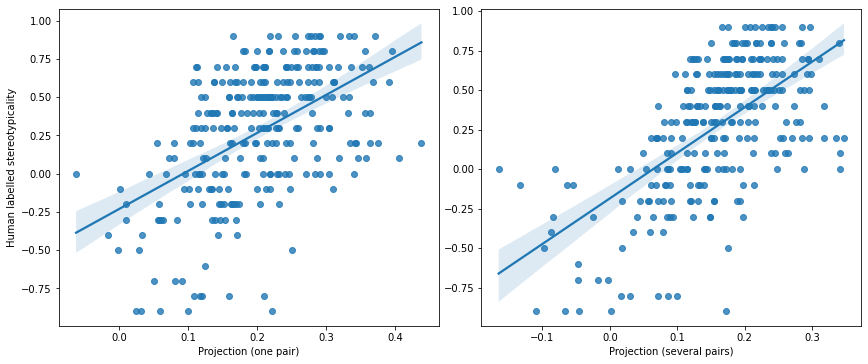

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

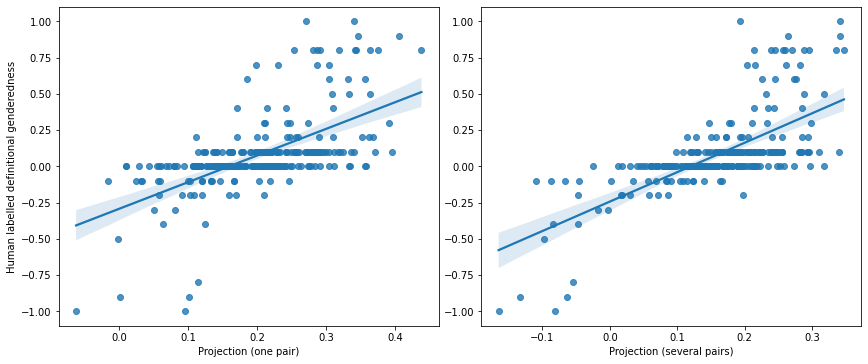

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

## More analogies

The paper defines a more advanced procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [ ]:
assert len(embedding.analogies(embedding['man']-embedding['woman'], ['actor', 'actress'])) == 1
assert type(embedding.analogies(embedding['man']-embedding['woman'], ['actor', 'actress'])) == list
assert type(embedding.analogies(embedding['man']-embedding['woman'], ['actor', 'actress'])[0]) == tuple

embedding.analogies(embedding['man']-embedding['woman'], ['actor', 'actress'])

[('actor', 'actress')]

In [ ]:
embedding.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businesswoman'),
 ('acquaintance', 'businesswoman'),
 ('actor', 'actress'),
 ('administrator', 'actress'),
 ('adventurer', 'businesswoman'),
 ('advocate', 'actress'),
 ('alderman', 'businesswoman'),
 ('ambassador', 'actress'),
 ('analyst', 'businesswoman'),
 ('anthropologist', 'actress'),
 ('archaeologist', 'actress'),
 ('archbishop', 'businesswoman'),
 ('architect', 'businesswoman'),
 ('artist', 'actress'),
 ('artiste', 'actress'),
 ('assassin', 'businesswoman'),
 ('astronaut', 'businesswoman'),
 ('astronomer', 'actress'),
 ('athlete', 'businesswoman'),
 ('attorney', 'paralegal'),
 ('author', 'businesswoman'),
 ('ballerina', 'actress'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'actress'),
 ('bartender', 'waitress'),
 ('biologist', 'businesswoman'),
 ('bishop', 'parishioner'),
 ('bodyguard', 'actress'),
 ('bookkeeper', 'homemaker'),
 ('broadcaster', 'actress'),
 ('broker', 'consultant'),
 ('bureaucrat', 'businesswoman'),
 ('businessman',